### Exercise 2
# Attention for Timeseries Prediction

This time we will learn how to implement attention and how it can improve prediction of timeseries data.

In [2]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

### PANJAPAN Dataset
Use `pandas` to read the PANJAPAN dataset. The dataset is organised as a directory full of CSV files, each of which contains a timeseries. Each timeseries has two values, a timestamp and a value.

In [3]:
timeseries = []

DATAPATH = Path(f"{os.getenv('HOME')}/Datasets/PANJAPAN/benchmarking")
for path in os.listdir(DATAPATH):
    if path.endswith(".csv") and (df := pd.read_csv(DATAPATH / path).to_numpy()).shape == (840, 2):
        timeseries.append(df)

timeseries = np.array(timeseries)
print("Length", len(timeseries))

Length 39


In [4]:
timeseries[0]

array([[1.1019200e+01, 1.5953238e+09],
       [1.1023500e+01, 1.5953274e+09],
       [1.1048700e+01, 1.5953310e+09],
       ...,
       [1.0214000e+01, 1.5983370e+09],
       [1.0202700e+01, 1.5983406e+09],
       [1.0201000e+01, 1.5983442e+09]])

### Visualize the Timeseries
Just to see what the dataset looks like, we make plots of the 

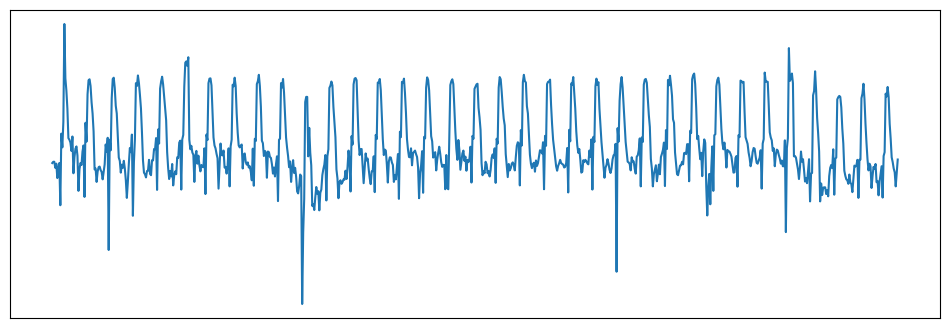

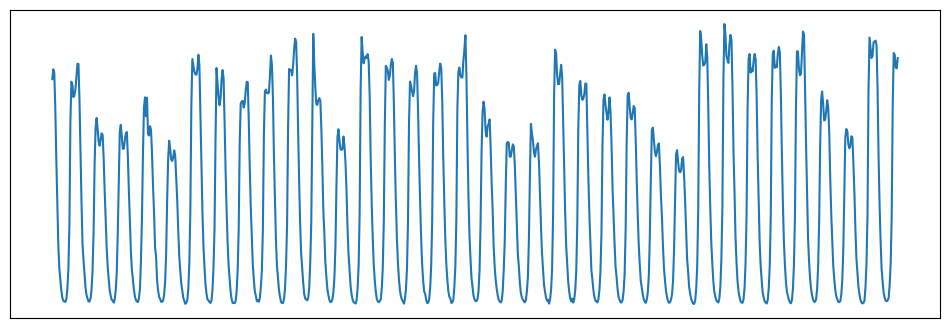

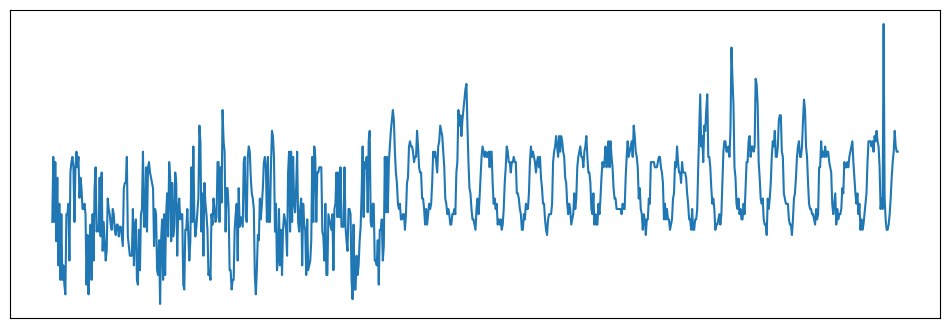

In [5]:
import matplotlib.pyplot as plt

def plot(value, timestamp):
    f = plt.figure(figsize=(12, 4))
    plt.plot(timestamp, value)
    plt.xticks([])
    plt.yticks([])
    return f

_ = plot(timeseries[15, :, 0], timeseries[15, :, 1])
_ = plot(timeseries[35, :, 0], timeseries[35, :, 1])
_ = plot(timeseries[30, :, 0], timeseries[30, :, 1])

We will now split the dataset into training, validation and testing splits.

In [6]:
from numpy.lib.stride_tricks import sliding_window_view

BACKCAST_LENGTH = 10
FORECAST_LENGTH = 3

def create_windows(series: np.ndarray, axis = 0):
    # Normalize
    mean = np.mean(series, axis=axis)
    std = np.std(series, axis=axis)
    try:
        series = (series - mean) / std
    except:
        ...

    windows = sliding_window_view(series, window_shape=BACKCAST_LENGTH + FORECAST_LENGTH, axis=axis).swapaxes(1, 2)
    windows = torch.tensor(windows)
    
    return windows

In [7]:
from torch.utils.data import DataLoader, random_split

# Set a seed to make experiments repeatable
torch.manual_seed(1337)

# Create three splits at 80%, 90% and 100% of the dataset
train_dataset, valid_dataset, tests_dataset = random_split(timeseries, lengths=(0.75, 0.05, 0.2))

### Build RNN to predict timeseries

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

def plot_updating(*series, figsize = (16, 4), marker='.', logplot = True):
    clear_output(wait=True)
    
    f = plt.figure(figsize=figsize)
    
    for points in series:
        plt.scatter(list(range(len(points))), points, 
            marker=marker, 
            alpha=max(0.1, min(10/len(points), 1.0)))
    
    if logplot:
        plt.semilogy()
    
    plt.show()
    display(plt.gcf())
    return f

<Figure size 640x480 with 0 Axes>

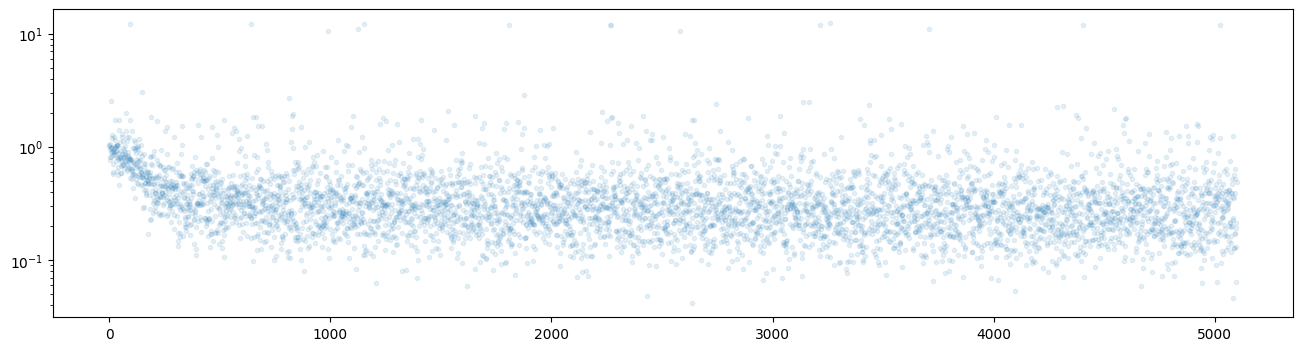

<Figure size 640x480 with 0 Axes>

Epoch 5/5: 100%|██████████| 1035/1035 [00:05<00:00, 187.24it/s]


<Figure size 640x480 with 0 Axes>

In [9]:
from torch.optim import SGD, Adam
from torch import nn

DEVICE = torch.device("mps")

class LSTM(nn.Module):
    def __init__(self, out_size, hidden_size = 5, num_layers = 2):
        super().__init__()
        
        self.lstm = nn.LSTM(1, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, out_size)
    
    def forward(self, seq):
        out, _ = self.lstm(seq)
        pred = self.linear(out)
        return pred[:, -1]

rnn_model = LSTM(out_size = FORECAST_LENGTH).to(DEVICE)
optimizer = Adam(params=rnn_model.parameters(), lr=2e-3)

losslog = []
valslog = []

for epoch in range(EPOCHS := 5):
    dataset = []
    for series in train_dataset:
        dataset.extend(create_windows(series))

    train_dataloader = DataLoader(dataset, shuffle=True, batch_size=24)
    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
        optimizer.zero_grad()

        horizon = batch[:, :BACKCAST_LENGTH, 0].to(dtype=torch.float32, device=DEVICE)
        target  = batch[:, BACKCAST_LENGTH:, 0].to(dtype=torch.float32, device=DEVICE)
        
        pred = rnn_model(horizon.unsqueeze(dim=2))
        loss = nn.functional.mse_loss(pred, target)
        
        loss.backward()    
        optimizer.step()
        
        losslog.append(loss.detach().cpu().item())
        
        if len(losslog) % 100 == 0:
            plot_updating(losslog)

In [12]:
@torch.no_grad()
def predict(series):
    windows = create_windows(series, axis=0).to(dtype=torch.float32, device=DEVICE)
    predictons = []
    targets = []

    wix = 0
    while wix < len(windows):
        window = windows[wix]
        
        horizon = window[:BACKCAST_LENGTH, 0]
        # if predictons:
        #     pred = torch.tensor(predictons[-BACKCAST_LENGTH:])
        #     horizon[-len(pred):] = pred
        #     horizon = horizon.to(dtype=torch.float32, device=DEVICE)
        
        pred = rnn_model(horizon.unsqueeze(dim=0).unsqueeze(dim=2))
        predictons.extend(pred.detach().cpu().numpy().flatten())
        
        target  = window[BACKCAST_LENGTH:, 0]
        targets.extend(target.detach().cpu().numpy().flatten())
        wix += len(target)
        
    f = plt.figure(figsize=(16, 4))
    plt.plot(targets, label="targets")
    plt.plot(predictons, label="predicton")
    plt.legend()
    plt.show()

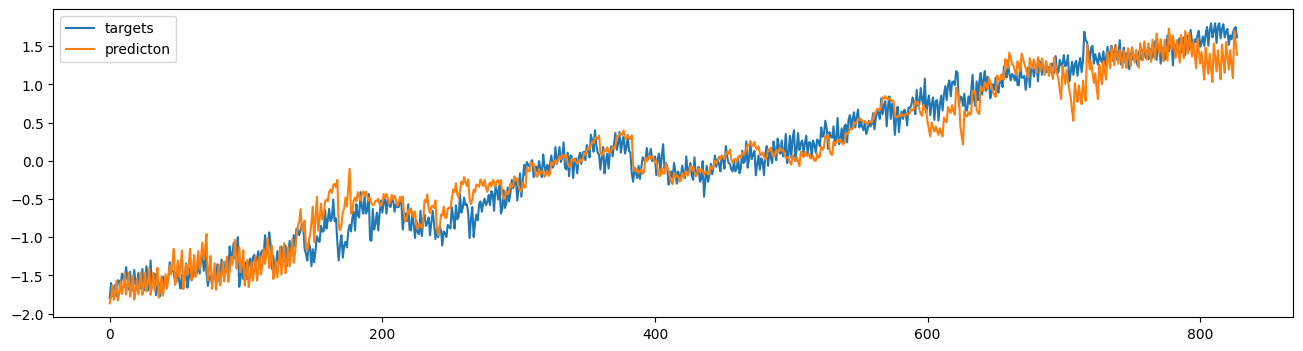

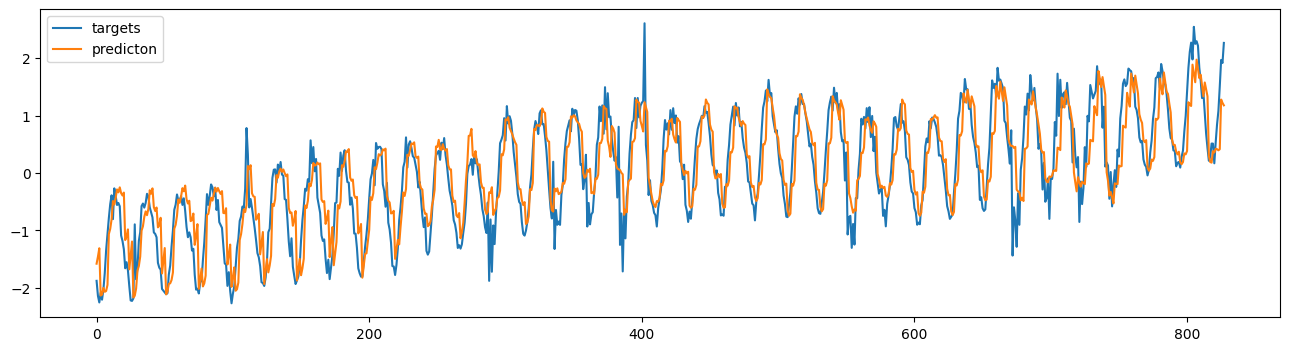

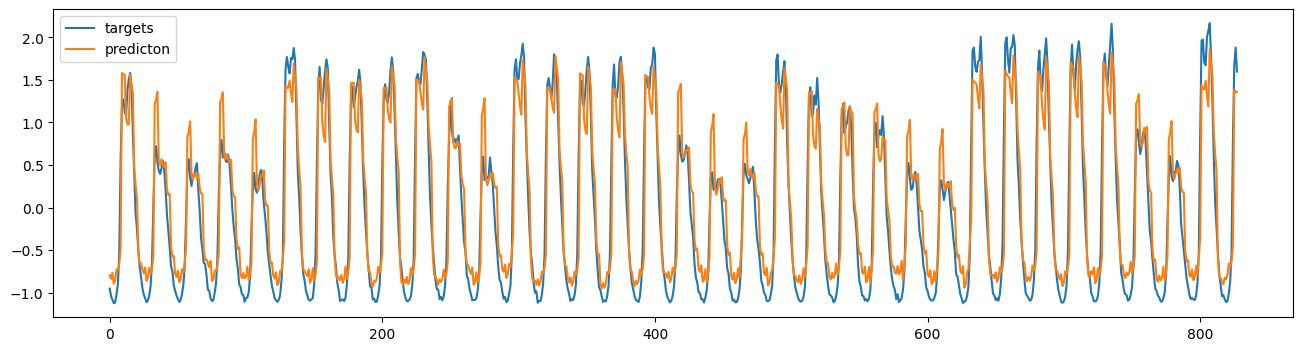

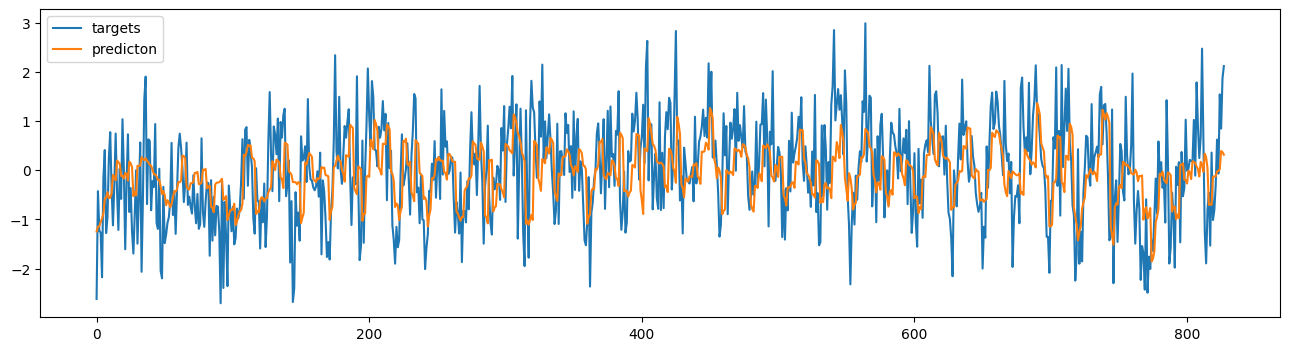

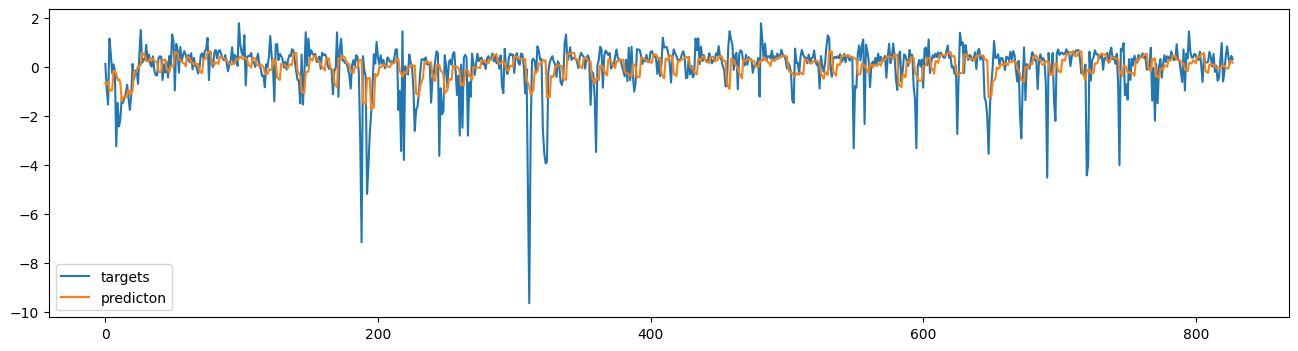

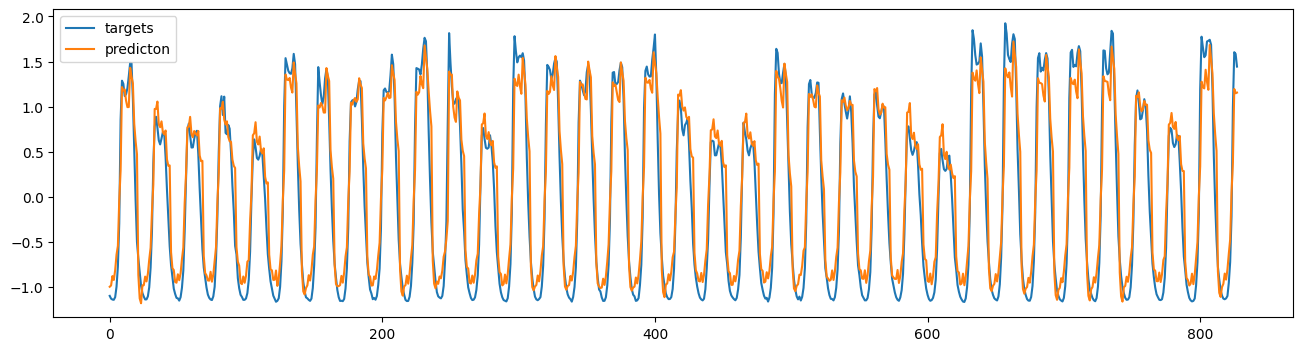

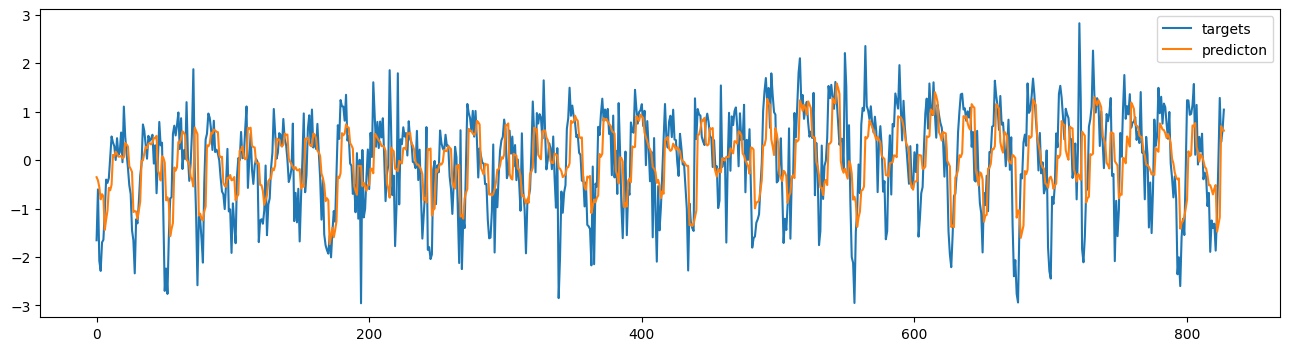

In [13]:
 
for series in tests_dataset:
    predict(series[:, 0].reshape(series.shape[0], 1))